# housing prediction
to do list:
- documentation.explain the reasons.
- github.
- lesson learned: when do get dummies, need to apply train and test together.

## import data and library.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all_df = pd.concat((train.iloc[:,:-1],test)) # combine test and train without sale price.
y_train = train["SalePrice"] 


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## data preprocessing

### check for skewness

In [25]:
numeric_feats = all_df.dtypes[all_df.dtypes != "object"].index
numeric_feats.shape

(37,)

In [55]:
# check how many of them have skewness above 0.75
from scipy.stats import skew
skewed_feats = all_df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats.shape

(22,)

In [27]:
# fig = plt.figure(figsize=(10,10))
# for counter, value in enumerate(skewed_feats):
    
#     plt.subplot(5, 5, counter+1)
#     sns.distplot(train[value].dropna())

In [56]:
all_df[skewed_feats] = np.log1p(all_df[skewed_feats])

In [29]:
y_train = np.log1p(y_train)

In [30]:
# fig = plt.figure(figsize=(10,10))
# for counter, value in enumerate(skewed_feats):
    
#     plt.subplot(5, 5, counter+1)
#     sns.distplot(train[value].dropna())

### change categorial to dummy

In [57]:
all_df = pd.get_dummies(all_df.iloc[:,:-1])


In [58]:
all_df.shape

(2919, 283)

### fill  NaN with mean

In [66]:
all_df = all_df.fillna(all_df.mean())


### preparing data for modeling

In [67]:
#create matrices for sklearn:
X_train = all_df[:train.shape[0]]
X_test = all_df[train.shape[0]:]

## model
- use L1 and L2 regularization

0.84922971505032707

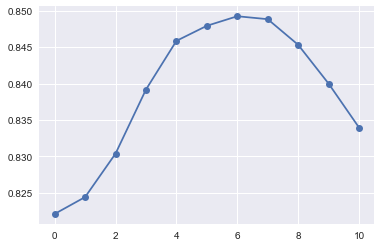

In [68]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,Lasso
from sklearn.model_selection import cross_val_score

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge =[]
for i in alphas:
    cv = cross_val_score(Ridge(alpha=i), X_train, y_train).mean()
    cv_ridge.append(cv)
plt.plot(cv_ridge,'-o')
max(cv_ridge)

/Users/yongsingyou/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/yongsingyou/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/yongsingyou/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/yongsingyou/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

[0.82248291423606901,
 0.82248234029498979,
 0.82248162245167578,
 0.82246861536662086]

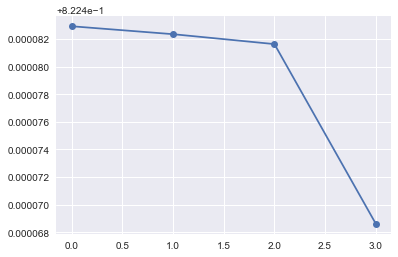

In [60]:
alphas = [1e-4,5e-4, 1e-3,1e-2]
cv_lasso =[]
for i in alphas:
    cv = cross_val_score(Lasso(alpha=i), X_train, y_train).mean()
    cv_lasso.append(cv)
plt.plot(cv_lasso,'-o')
cv_lasso

In [40]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
cross_val_score(model_lasso,X_train, y_train).mean(),model_lasso.alpha_

(0.89719951393109232, 0.001)

In [46]:
coef = pd.Series(model_lasso.coef_, index = X_train1.columns)
abs(coef).sort_values(ascending=False)

GrLivArea               0.131589
OverallQual             0.057605
YearBuilt               0.052154
RoofMatl_ClyTile        0.044855
LotArea                 0.043129
OverallCond             0.042029
MSZoning_C (all)        0.034514
BsmtFinSF1              0.024424
Condition2_PosN         0.023609
1stFlrSF                0.022273
TotalBsmtSF             0.020898
GarageArea              0.020663
Neighborhood_Crawfor    0.020587
GarageCars              0.019404
KitchenQual_Ex          0.018007
Neighborhood_StoneBr    0.017796
Neighborhood_NridgHt    0.017391
Functional_Typ          0.015895
Neighborhood_Edwards    0.015327
YearRemodAdd            0.015270
Neighborhood_NoRidge    0.015076
BsmtFullBath            0.014956
Exterior1st_BrkFace     0.013750
BsmtQual_Ex             0.013723
Fireplaces              0.013563
BsmtExposure_Gd         0.013450
Condition1_Norm         0.013298
SaleType_New            0.013075
Functional_Maj2         0.012824
KitchenAbvGr            0.011006
          

In [88]:
### output this to Kaggle
las = Lasso(alpha= 0.0005).fit(X_train,y_train)
Y_predi = las.predict(X_test)
Y_predi = np.expm1(Y_predi) # reverse to normal value
submission = pd.DataFrame({'Id':test['Id'],"SalePrice":Y_predi})
submission.to_csv("submission_lasso.csv", index = False)

In [90]:
rid = Ridge(alpha= 5).fit(X_train,y_train)
Y_predi = rid.predict(X_test)
Y_predi = np.expm1(Y_predi) # reverse to normal value
submission = pd.DataFrame({'Id':test['Id'],"SalePrice":Y_predi})
submission.to_csv("submission_rid.csv", index = False)

## try other

In [74]:
import lightgbm as lgb
lgb_r = lgb.LGBMRegressor()
lgb_r.fit(X_train,y_train)
Y_predi = lgb_r.predict(X_test)
Y_predi = np.expm1(Y_predi) # reverse to normal value
submission = pd.DataFrame({'Id':test['Id'],"SalePrice":Y_predi})
submission.to_csv("submission_lgb.csv", index = False)


In [75]:
from sklearn.ensemble import RandomForestRegressor 
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train,y_train)
Y_predi = forest_reg.predict(X_test)
Y_predi = np.expm1(Y_predi) # reverse to normal value
submission = pd.DataFrame({'Id':test['Id'],"SalePrice":Y_predi})
submission.to_csv("submission_forest.csv", index = False)

## scratchpad

In [ ]:
>>> from sklearn import datasets, linear_model
>>> from sklearn.model_selection import cross_val_score
>>> diabetes = datasets.load_diabetes()
>>> X = diabetes.data[:]
>>> y = diabetes.target[:]
>>> lasso = linear_model.Lasso()

>>> print(cross_val_score(Ridge(), X, y))  


In [ ]:
cv_ridge= []
cv_ridge.append(1)
cv_ridge

In [ ]:
diabetes.data.shape

In [ ]:
diabetes.target.shape

In [ ]:
X.shape

In [ ]:
Ridge

In [18]:
X_train

NameError: name 'X_train' is not defined